<a href="https://colab.research.google.com/github/JacobDowns/CSCI-491-591/blob/main/hydraulic_erosion_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing (Part of) A Hydraulic Erosion Model in NumPy




In this Notebook, we'll walk through how to implement a somewhat complex numerical model in NumPy by translating from some regular Python code that makes ample use of for loops to a model that uses purely NumPy vectorized operations.

In particular, we'll be implementing a model of water flow that is used in simulations of hydraulic erosion described in this paper [Fast Hydraulic Erosion Simulation and Visualization on
GPU](https://inria.hal.science/inria-00402079/document). Hydraulic erosion is the process by which landscapes are reshaped via transportation of sediment by water.


To start, we'll look at an existing implementation of the model presented in this paper [here](https://github.com/keepitwiel/hydraulic-erosion-simulator/tree/main). Notably, this implementation uses Numba, which makes it very performant. However, the difference between very fast code and very slow code is a matter of using the `@njit` decorator as we'll discuss later. For now, let's pretend that this was implemented purely in pure Python.

While beyond the scope of this notebook, there is an incrediby cool, and somewhat more complex hydrology model [here](https://github.com/weigert/SimpleHydrology) by Nick McDonald that simulates additional processes like river meanders.

<figure>
<center>
<img src='https://raw.githubusercontent.com/weigert/SimpleHydrology/refs/heads/master/screenshots/side3.png' />
<figcaption>Snapshot of the SimpleHydrology model by Nick McDonald.</figcaption></center>
</figure>


## A Quick Overview of the Model

The hydraulic erosion model simulates a few main physical processes:

* Water falls as rain on some starting landscape
* Water flows downhill
* As water flows it can pick up sediment and deposit it somewhere else
* Water evaporates as it flows


For our purposes we don't need to have much insight into the physics of the model except to familiarize ourselves with its basic components. Instead, we need to think about how to translate the numerical operations in the Python code code to vectorized operations in NumPy.

## Original code
In this notebook we'll implement the most complex part of the hydraulic erosion model which is the water flow model. This portion of the model simulates how water flows over the terrain forming rivers and lakes. I've broken out and slightly altered the water transport part of the model's original code below.

**Water Flow Constants**

In [1]:
# Simulation constants taken from original code
A_PIPE = 0.6  # virtual pipe cross section
G = 9.81      # gravitational acceleration
L_PIPE = 1    # virtual pipe length
LX = 1        # horizontal distance between grid points
LY = 1        # vertical distance between grid points
K_E = 0.003   # evaporation constant

**Water Flow Update**

This code takes in the model's state at a given time and advances to the next time step. For the moment we'll assume that the terrain height $z$ is constant and only the water height $h$, fluxes, and water velocity change through time. That is, we aren't implementing the movement and deposition of sediment yet.

In [2]:
def update_flow(
    z,   # Terrain height [ny, nx]
    h,   # Water height [ny, nx]
    r,   # Rainfall rate [ny, nx]
    u,   # x-velocity [ny, nx]
    v,   # y-velocity [ny, nx]
    fL,  # Flux to left  neighbor [ny, nx]
    fR,  # Flux to right neighbor [ny, nx]
    fT,  # Flux to top   neighbor [ny, nx]
    fB,  # Flux to bottom neighbor [ny, nx]
    dt,  # Time step (s)
    k_e = K_E  # Evaporation rate (height units per second, constant)
):
    """
    One Euler step of the 2D shallow “virtual pipes” water-flow model (no erosion),
    updating all fields **in place**.

    Model summary
    -------------
    1) Rainfall: h1 = h + r*dt (applied in place to `h`).
    2) Outflow fluxes (eqns 2–3): For each interior cell, grow directional fluxes
       proportional to surface height differences H = z + h_pre_rain (pre-rain),
       then clamp to ≥0.
    3) Adjustment (eqns 4–5): Scale outflows so a cell cannot lose more water than
       it has.
    4) Continuity (eqns 6–7): Update water height by net inflow/outflow.
    5) Velocities (eqns 8–9): Compute u,v using mean water level h_mean = h1 + 0.5*dh.
    6) Evaporation (constant-rate variant): h = max(0, h2 - k_e*dt).

    Parameters
    ----------
    z, h, r, u, v, fL, fR, fT, fB : np.ndarray, shape (ny, nx)
        State arrays, all updated in place. `z` is unchanged here.
    dt : float
        Time step (seconds).
    k_e : float, optional
        Constant evaporation rate (height units per second).

    Notes
    -----
    - Indices follow NumPy convention: j=row (y), i=col (x). Interior is 1..ny-2, 1..nx-2.
    - Boundary fluxes are zeroed to prevent leaks.
    - This routine performs **in-place** updates; a return value is provided only
      for convenience.

    Returns
    -------
    z, h, r, u, v, fL, fR, fT, fB, dt, k_e
        Same objects passed in (all but `z` modified as described).
    """
    n_y, n_x = z.shape

    # Pre-rain surface height (H must reflect pre-rain h per the paper/code)
    H = np.zeros_like(h)
    for j in range(n_y):
        for i in range(n_x):
            H[j, i] = z[j, i] + h[j,i]

    # 1) Rainfall: h <- h1 = h + r*dt
    for j in range(n_y):
        for i in range(n_x):
            h[j, i] += r[j, i] * dt  # h now holds h1

    # Constants for flux growth
    flux_factor = dt * A_PIPE / L_PIPE * G

    # 2) Outflow fluxes and 3) Adjustment (interior only)
    for j in range(1, n_y - 1):
        for i in range(1, n_x - 1):
            # Height diffs from pre-rain surface
            dhL = H[j, i] - H[j, i - 1]
            dhR = H[j, i] - H[j, i + 1]
            dhT = H[j, i] - H[j - 1, i]
            dhB = H[j, i] - H[j + 1, i]

            # Grow fluxes, clamp to >= 0
            fL[j, i] = max(0.0, fL[j, i] + dhL * flux_factor)
            fR[j, i] = max(0.0, fR[j, i] + dhR * flux_factor)
            fT[j, i] = max(0.0, fT[j, i] + dhT * flux_factor)
            fB[j, i] = max(0.0, fB[j, i] + dhB * flux_factor)

            # Adjustment to prevent negative water height
            sum_f = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]
            if sum_f > 0.0:
                # h[j,i] is h1 at this point
                adj = min(1.0, (h[j, i] * LX * LY) / (sum_f * dt))
                fL[j, i] *= adj
                fR[j, i] *= adj
                fT[j, i] *= adj
                fB[j, i] *= adj

    # Zero boundary fluxes (rows first index, cols second index)
    for i in range(n_x):
        fL[0, i]      = 0.0           # top row: no left-out flow crossing boundary
        fR[n_y - 1, i]= 0.0           # bottom row
    for j in range(n_y):
        fT[j, 0]      = 0.0           # left column
        fB[j, n_x - 1]= 0.0           # right column

    # 4) Continuity + 5) Velocities + 6) Evaporation (interior only)
    for j in range(1, n_y - 1):
        for i in range(1, n_x - 1):
            # Net inflow/outflow using current fluxes
            sum_f_in = (
                fR[j, i - 1] +  # from left neighbor
                fT[j + 1, i] +  # from bottom neighbor
                fL[j, i + 1] +  # from right neighbor
                fB[j - 1, i]    # from top neighbor
            )
            sum_f_out = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]

            dvol = dt * (sum_f_in - sum_f_out)
            dh   = dvol / (LX * LY)

            # h currently holds h1; keep a local copy for velocity mean
            h1_cell = h[j, i]
            h2_cell = h1_cell + dh

            # Mean water level for velocity (pre/post average)
            h_mean = h1_cell + 0.5 * dh

            if h_mean > 0.0:
                dwx = (fR[j, i - 1] - fL[j, i] +
                       fR[j, i]     - fL[j, i + 1])
                dwy = (fB[j - 1, i] - fT[j, i] +
                       fB[j, i]     - fT[j + 1, i])

                u[j, i] = dwx / (LY * h_mean)
                v[j, i] = dwy / (LX * h_mean)
            else:
                u[j, i] = 0.0
                v[j, i] = 0.0

            # Evaporation from updated height
            h[j, i] = max(0.0, h2_cell - k_e * dt)

    return z, h, r, u, v, fL, fR, fT, fB, dt, k_e

## Testing the Model
Let's test the model on some randomly generated terrain. Below I'll design a function that builds terrain using random noise and Gaussian smoothing.

In [4]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

def generate_terrain(n, steps=10):
    """
    Generate a square heightmap (terrain) by summing multi-scale Gaussian-blurred noise.

    The procedure builds terrain-like structure by repeatedly sampling white noise and
    blurring it with progressively smaller Gaussian kernels. Early iterations (large
    sigma) contribute broad, low-frequency features (big hills), while later iterations
    (small sigma) add high-frequency detail (ridges/bumps). The final map is min–max
    normalized to the range [0, 1].

    Parameters
    ----------
    n : int
        Size of the terrain grid; output has shape (n, n).
    steps : int, optional
        Number of noise “octaves”. More steps add more high-frequency detail.
        Default is 10.

    Returns
    -------
    z : ndarray of shape (n, n), dtype float
        Heightmap normalized to [0, 1].

    Notes
    -----
    - Randomness is unseeded; call `np.random.seed(...)` beforehand (or use a Generator)
      for reproducible terrain.
    - This is a simple multi-scale noise synthesis; for different spectral characteristics,
      you could weight each octave (e.g., 1/2^i) or change the sigma schedule.

    Examples
    --------
    >>> z = generate_terrain(256, steps=8)
    >>> plt.imshow(z, cmap="terrain"); plt.colorbar(); plt.show()
    """
    # Initialize the heightmap accumulator.
    z = np.zeros((n, n), dtype=float)

    for i in range(steps):
        # 1) Sample white noise ~ N(0, 1).
        z_i = np.random.randn(n, n)

        # 2) Choose Gaussian blur scale (in pixels).
        #    Large sigma for early octaves -> smooth, low-frequency structure.
        #    As i grows, sigma shrinks -> adds finer details.
        sigma = float(n / (2.0 * (i + 1)))

        # 3) Blur the noise to control its spatial frequency content.
        #    'mode="reflect"' avoids edge artifacts by mirroring at boundaries.
        z_i = gaussian_filter(z_i, sigma=sigma, mode="reflect")

        # 4) Accumulate this octave into the terrain.
        z += z_i

    # 5) Normalize to [0, 1] for convenient visualization/use.
    z_min, z_max = z.min(), z.max()
    if z_max > z_min:
        z = (z - z_min) / (z_max - z_min)
    else:
        # Degenerate case: constant array (extremely unlikely); pick mid-gray.
        z.fill(0.5)

    return z



Now let's use the terrain generation function to create an example landscape and simulate waterflow.

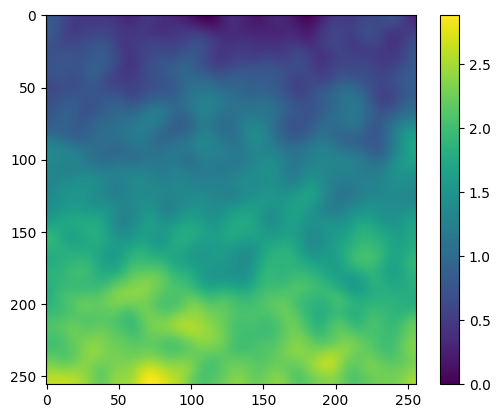

In [6]:
# Example of the terrain creation function. This make a ramp + some noise
z = generate_terrain(256, steps=20) + np.linspace(0.,2.,256)[:,None]
plt.imshow(z)
plt.colorbar()
plt.show()

Now let's define a convenience function for doing a simulation loop.

In [7]:
import numpy as np

def simulate(z, update_func, T=10.0, dt=0.2):
    """
    Run a water-flow simulation and collect time histories of water height (h)
    and velocities (u, v).

    This function sets up state arrays (h, u, v, directional fluxes) and then
    advances the system from t=0 to t=T using the provided `update_func`. At
    each time step it stores snapshots of h, u, and v. The update function is
    expected to mutate the passed arrays in place.
    If your function returns updated arrays, the return value is
    simply ignored and the in-place state is recorded.

    Parameters
    ----------
    z : ndarray (ny, nx)
        Terrain height field (unchanged by this function).
    update_func : callable
        A function that performs one time step. It should accept at least:
            (z, h, r, u, v, fL, fR, fT, fB, dt, ...)
        and update `h`, `u`, `v`, and the fluxes in place.
        Example: `update_flow(z, h, r, u, v, fL, fR, fT, fB, dt, k_e=...)`
    T : float, optional
        Total simulated time in seconds (default 10.0).
    dt : float, optional
        Time-step size in seconds (default 0.1).

    Returns
    -------
    times : ndarray (n_t,)
        Times corresponding to each stored snapshot.
    H_hist : ndarray (n_t, ny, nx)
        Water height snapshots at every step.
    U_hist : ndarray (n_t, ny, nx)
        x-velocity snapshots at every step.
    V_hist : ndarray (n_t, ny, nx)
        y-velocity snapshots at every step.
    final_state : dict
        References to the final state arrays (h, u, v, fL, fR, fT, fB) for reuse.

    Notes
    -----
    - A simple rainfall schedule is used by default: constant light rain for the
      first half of the simulation, then no rain. Edit the `rain_rate` and the
      `if t < T/2` condition below to suit your experiment, or replace it with
      your own schedule.
    - Memory usage scales with n_t * ny * nx because we store a snapshot every
      step. If you only need sparse frames, store every k-th step.
    """
    assert dt > 0, "dt must be positive"
    ny, nx = z.shape

    # Construct an inclusive time grid: 0, dt, ..., T
    times = np.arange(0.0, T + 1e-12, dt)
    n_t = times.size


    # Allocate state arrays
    # -------------------------------
    h  = np.zeros((ny, nx), dtype=float)  # water height
    u  = np.zeros_like(h)                 # x-velocity
    v  = np.zeros_like(h)                 # y-velocity

    # Directional fluxes
    fL = np.zeros_like(h)
    fR = np.zeros_like(h)
    fT = np.zeros_like(h)
    fB = np.zeros_like(h)

    # Rainfall field (per-cell rate).
    r = np.zeros_like(h)


    # Allocate histories
    # -----------------------------------
    H_hist = np.empty((n_t, ny, nx), dtype=h.dtype)
    U_hist = np.empty_like(H_hist)
    V_hist = np.empty_like(H_hist)

    # Rate of rainfall
    rain_rate = 1e-2


    # Main time-stepping
    # ----------------
    for k, t in enumerate(times):
        # Update rainfall for this step
        if t < T / 2.0:
            r.fill(rain_rate)
        else:
            r.fill(0.0)

        # Advance one step. We don't rely on return values; arrays are updated in place.
        _ = update_func(z, h, r, u, v, fL, fR, fT, fB, dt)

        # Store snapshots
        H_hist[k] = h
        U_hist[k] = u
        V_hist[k] = v

    final_state = dict(h=h, u=u, v=v, fL=fL, fR=fR, fT=fT, fB=fB)
    return times, H_hist, U_hist, V_hist, final_state



Now let's define a function that will animate the model output.

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML, display, Video

def animate_from_sim(
    sim_result,
    *,
    interval=60,              # milliseconds between frames
    time_stride=1,            # show every k-th frame to keep it light
    h_vmin=None, h_vmax=None, # fixed color scale for h; if None, use robust percentiles
    s_vmin=None, s_vmax=None, # fixed color scale for speed magnitude
    percentile_clip=(1, 99),  # used when vmin/vmax are None
    embed_limit_mb=64,        # raise inline embed cap (MB) for large animations
    save_h=None,              # e.g. "/mnt/data/h.mp4" or ".gif"
    save_s=None,              # e.g. "/mnt/data/speed.gif"
    fps=20,                   # when saving to file
    show_inline=True,         # display inline JSHTML
    link_instead_of_embed=False  # if saving mp4, show a file link/player instead of embedding
):
    """
    Animate the results of `simulate(...)` in a Jupyter notebook.

    Parameters
    ----------
    sim_result : tuple
        Output from `simulate(...)`, i.e.:
            (times, H_hist, U_hist, V_hist, final_state)
        where:
            times   : (T,) array of times
            H_hist  : (T, ny, nx) water height snapshots
            U_hist  : (T, ny, nx) x-velocity snapshots
            V_hist  : (T, ny, nx) y-velocity snapshots
            final_state : dict (unused here, just passed through)
    interval : int
        Milliseconds between frames in the inline animation.
    time_stride : int
        Use every k-th frame (≥1). Helpful for long runs.
    h_vmin, h_vmax : float or None
        Fixed color limits for water height. If None, computed from robust percentiles.
    s_vmin, s_vmax : float or None
        Fixed color limits for speed magnitude. If None, computed from robust percentiles.
    percentile_clip : (lo, hi)
        Percentiles for robust scaling when vmin/vmax are None (e.g. (1, 99)).
    embed_limit_mb : int
        Increases Matplotlib's inline embed size limit to avoid warning for big animations.
    save_h, save_s : str or None
        Paths to save the animations. Use ".mp4" (smaller, needs ffmpeg) or ".gif" (bigger).
    fps : int
        Frames per second when saving.
    show_inline : bool
        If True, display the animations inline via JSHTML.
    link_instead_of_embed : bool
        If True and saving MP4, display a notebook Video widget that references the file
        instead of embedding the whole animation payload (keeps notebook size small).

    Returns
    -------
    (anim_h, fig_h), (anim_s, fig_s)
        The Matplotlib animation and figure handles for `h` and `|v|`.
    """
    # Unpack simulation outputs
    times, H_hist, U_hist, V_hist, _final = sim_result

    # Subsample time axis if requested
    idx = np.arange(0, len(times), max(1, int(time_stride)))
    t  = times[idx]
    Hs = H_hist[idx]
    Us = U_hist[idx]
    Vs = V_hist[idx]
    Sp = np.sqrt(Us**2 + Vs**2)  # speed magnitude stack, shape (T', ny, nx)

    # Robust global color scales so colors are consistent across frames
    def robust_limits(A, vmin, vmax):
        if (vmin is not None) and (vmax is not None):
            return vmin, vmax
        finite = A[np.isfinite(A)]
        if finite.size == 0:
            return None, None
        lo, hi = np.percentile(finite, percentile_clip)
        return (vmin if vmin is not None else lo,
                vmax if vmax is not None else hi)

    h_vmin, h_vmax = robust_limits(Hs, h_vmin, h_vmax)
    s_vmin, s_vmax = robust_limits(Sp, s_vmin, s_vmax)

    # Raise inline embed size limit to avoid the ~20MB default cap
    mpl.rcParams['animation.embed_limit'] = float(embed_limit_mb)

    # ------------------------
    # Animation for water h(t)
    # ------------------------
    fig_h, ax_h = plt.subplots(figsize=(5, 5))
    im_h = ax_h.imshow(Hs[0], vmin=h_vmin, vmax=h_vmax, animated=True)
    cb_h = plt.colorbar(im_h, ax=ax_h, fraction=0.046, pad=0.04)
    ax_h.set_title("Water height h")
    ax_h.set_xlabel(f"t={t[0]:.3f}  (frame 0/{len(t)-1})")

    def _h_init():
        im_h.set_data(Hs[0])
        return (im_h,)

    def _h_update(k):
        im_h.set_data(Hs[k])
        ax_h.set_xlabel(f"t={t[k]:.3f}  (frame {k}/{len(t)-1})")
        return (im_h,)

    anim_h = FuncAnimation(fig_h, _h_update, init_func=_h_init,
                           frames=len(t), interval=interval, blit=True)

    # Display inline (JSHTML) or save
    if show_inline:
        html = anim_h.to_jshtml()
        plt.close(fig_h)  # prevent duplicate static image
        display(HTML(html))

    if save_h:
        if save_h.lower().endswith(".gif"):
            anim_h.save(save_h, writer=PillowWriter(fps=fps))
        else:
            anim_h.save(save_h, writer="ffmpeg", fps=fps)
        if link_instead_of_embed and save_h.lower().endswith(".mp4"):
            display(Video(save_h, embed=False))

    # --------------------------------------
    # Animation for speed magnitude |v|(t)
    # --------------------------------------
    fig_s, ax_s = plt.subplots(figsize=(5, 5))
    im_s = ax_s.imshow(Sp[0], vmin=s_vmin, vmax=s_vmax, animated=True)
    cb_s = plt.colorbar(im_s, ax=ax_s, fraction=0.046, pad=0.04)
    ax_s.set_title("Velocity magnitude |v|")
    ax_s.set_xlabel(f"t={t[0]:.3f}  (frame 0/{len(t)-1})")

    def _s_init():
        im_s.set_data(Sp[0])
        return (im_s,)

    def _s_update(k):
        im_s.set_data(Sp[k])
        ax_s.set_xlabel(f"t={t[k]:.3f}  (frame {k}/{len(t)-1})")
        return (im_s,)

    anim_s = FuncAnimation(fig_s, _s_update, init_func=_s_init,
                           frames=len(t), interval=interval, blit=True)

    if show_inline:
        html = anim_s.to_jshtml()
        plt.close(fig_s)
        display(HTML(html))

    if save_s:
        if save_s.lower().endswith(".gif"):
            anim_s.save(save_s, writer=PillowWriter(fps=fps))
        else:
            anim_s.save(save_s, writer="ffmpeg", fps=fps)
        if link_instead_of_embed and save_s.lower().endswith(".mp4"):
            display(Video(save_s, embed=False))

    return (anim_h, fig_h), (anim_s, fig_s)


Okay, now let's use the convenience functions we defined to perform and visualize a simulation.

In [ ]:
times, H_hist, U_hist, V_hist, final_state = simulate(z, update_flow, T=50.0, dt=0.2)

plt.title('Terrain height H')
plt.imshow(z)
plt.colorbar()
plt.show()

# Mask the velocity where the water height is very low.
mask = H_hist > 5e-3
U_hist *= mask
V_hist *= mask


animate_from_sim(
    (times, H_hist, U_hist, V_hist, final_state),
    interval=50,
    time_stride=1,
    embed_limit_mb=64,
    fps=20,
    show_inline=True,
    link_instead_of_embed=True
)

## Translating to NumPy
Let's step through the process of converting these Python loops to NumPy based array operations. Consider the first few chunks of code in the `update_flow` function:

```
n_y, n_x = z.shape

# Pre-rain surface height (H must reflect pre-rain h per the paper/code)
H = np.zeros_like(h)
for j in range(n_y):
    for i in range(n_x):
        H[j, i] = z[j, i] + h[j,i]

# 1) Rainfall: h <- h1 = h + r*dt
for j in range(n_y):
    for i in range(n_x):
        h[j, i] += r[j, i] * dt  # h now holds h1

# Constants for flux growth
flux_factor = dt * A_PIPE / L_PIPE * G
```

Converting these operations to NumPy is straightforward. For example, the first loop can easily be replaced with
```
H = z + h
```
using vectorized operations. Similarly, the second for loop can be written as
```
h += r*dt
```

**Flux Computations**


We can use NumPy's indexing features to translate the loops responsible for computation of the fluxes.

```
for j in range(1, n_y - 1):
    for i in range(1, n_x - 1):
        # Height diffs from pre-rain surface
        dhL = H[j, i] - H[j, i - 1]
        dhR = H[j, i] - H[j, i + 1]
        dhT = H[j, i] - H[j - 1, i]
        dhB = H[j, i] - H[j + 1, i]

        # Grow fluxes, clamp to >= 0
        fL[j, i] = max(0.0, fL[j, i] + dhL * flux_factor)
        fR[j, i] = max(0.0, fR[j, i] + dhR * flux_factor)
        fT[j, i] = max(0.0, fT[j, i] + dhT * flux_factor)
        fB[j, i] = max(0.0, fB[j, i] + dhB * flux_factor)

        # Adjustment to prevent negative water
        sum_f = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]
        if sum_f > 0.0:
            # h[j,i] is h1 at this point
            adj = min(1.0, (h[j, i] * LX * LY) / (sum_f * dt))
            fL[j, i] *= adj
            fR[j, i] *= adj
            fT[j, i] *= adj
            fB[j, i] *= adj
```

Note that this loops over the interior elements in the state variable arrays. That is, these loops iterate over all elements except those on the edges. For convenience, we can create NumPy slices that refer to only the interior elements to avoid redundancy with indexing.

```
inner = (slice(1, ny - 1), slice(1, nx - 1))
```

Using these slices, the following lines can be removed from a loop
```
dhL = H[j, i] - H[j, i - 1]
dhR = H[j, i] - H[j, i + 1]
dhT = H[j, i] - H[j - 1, i]
dhB = H[j, i] - H[j + 1, i]
```
and be replaced by the corresponding lines outside of a loop:
```
dhL = H[inner] - H[1:-1, 0:-2]
dhR = H[inner] - H[1:-1, 2:  ]
dhT = H[inner] - H[0:-2, 1:-1]
dhB = H[inner] - H[2:  , 1:-1]
```
Similarly, computing the values
```
fL[j, i] = max(0.0, fL[j, i] + dhL * flux_factor)
fR[j, i] = max(0.0, fR[j, i] + dhR * flux_factor)
fT[j, i] = max(0.0, fT[j, i] + dhT * flux_factor)
fB[j, i] = max(0.0, fB[j, i] + dhB * flux_factor)
```
can be done using vectorized operations without any explicit for loops. Hence, these computations will be replace by
```
fL[inner] = np.maximum(0.0, fL[inner] + dhL * flux_factor)
fR[inner] = np.maximum(0.0, fR[inner] + dhR * flux_factor)
fT[inner] = np.maximum(0.0, fT[inner] + dhT * flux_factor)
fB[inner] = np.maximum(0.0, fB[inner] + dhB * flux_factor)
```
where we use `np.maximum` instead of `max`.

**Computing Adjusted Fluxes**

Now we'll address the lines for computing the adjusted fluxes. This flux adjustement is included in the model to make sure the water height doesn't become negative, which is non-physical.
```
sum_f = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]
if sum_f > 0.0:
    # h[j,i] is h1 at this point
    adj = min(1.0, (h[j, i] * LX * LY) / (sum_f * dt))
    fL[j, i] *= adj
    fR[j, i] *= adj
    fT[j, i] *= adj
    fB[j, i] *= adj
```
The first line, is easy recalling that we are computing sums of fluxes only on interior cells.
```
sum_f_inner = fL[inner] + fR[inner] + fT[inner] + fB[inner]
```
We need some logic that if `sum_f_inner` is 0, then we multiply the fluxes by an adjustment factor. Naively, we could compute the adjustment factor as
```
adj = np.minimum(1.0, (h[inner] * LX * LY) / (sum_f_inner * dt))
```
but this could be problematic since `sum_f_inner` could be 0. In such a case, the corresponding values in `adj` would be `NaN` or not a number values. To get around this we can do the following:
```
adj = np.ones_like(sum_f_inner)
mask = sum_f_inner > 0.
adj[mask] = h_inner[mask]*LX*LY / (sum_f_inner[mask] * dt)
adj = np.minimum(1., adj)
fL_inner *= adj
fR_inner *= adj
fT_inner *= adj
fB_inner *= adj
```
Here, we are only computing the adjustment factor when `sum_f_inner` is not 0. Otherwise it will just be 1. Observe that multiplying by an adjustment factor of 1 does not change the fluxes at those locations.

**Boundary Fluxes**

Setting the boundary fluxes is easy in NumPy. The loops
```
for i in range(n_x):
    fL[0, i]      = 0.0           # top row: no left-out flow crossing boundary
    fR[n_y - 1, i]= 0.0           # bottom row
for j in range(n_y):
    fT[j, 0]      = 0.0           # left column
    fB[j, n_x - 1]= 0.0           # right column
```
are replaced by the lines:
```
fL[0,  :] = 0.0
fR[-1, :] = 0.0
fT[:,  0] = 0.0
fB[:, -1] = 0.0
```

**Continuity Equation**

Let's now address the final big loop, which solves the continuity equation, computes velocities, and also accounts for evaporation.
```
for j in range(1, n_y - 1):
      for i in range(1, n_x - 1):
          # Net inflow/outflow using current fluxes
          sum_f_in = (
              fR[j, i - 1] +  # from left neighbor
              fT[j + 1, i] +  # from bottom neighbor
              fL[j, i + 1] +  # from right neighbor
              fB[j - 1, i]    # from top neighbor
          )
          sum_f_out = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]

          dvol = dt * (sum_f_in - sum_f_out)
          dh   = dvol / (LX * LY)

          # h currently holds h1; keep a local copy for velocity mean
          h1_cell = h[j, i]
          h2_cell = h1_cell + dh

          # Mean water level for velocity (pre/post average)
          h_mean = h1_cell + 0.5 * dh

          if h_mean > 0.0:
              dwx = (fR[j, i - 1] - fL[j, i] +
                      fR[j, i]     - fL[j, i + 1])
              dwy = (fB[j - 1, i] - fT[j, i] +
                      fB[j, i]     - fT[j + 1, i])

              u[j, i] = dwx / (LY * h_mean)
              v[j, i] = dwy / (LX * h_mean)
          else:
              u[j, i] = 0.0
              v[j, i] = 0.0

          # Evaporation from updated height
          h[j, i] = max(0.0, h2_cell - k_e * dt)
```

We no longer need loops to compute the quantities for sums of fluxes.
```
sum_f_in = (
    fR[j, i - 1] +  # from left neighbor
    fT[j + 1, i] +  # from bottom neighbor
    fL[j, i + 1] +  # from right neighbor
    fB[j - 1, i]    # from top neighbor
)
sum_f_out = fL[j, i] + fR[j, i] + fT[j, i] + fB[j, i]
```
They'll be replaced by with vector operations and some slicing.
```
sum_f_in = (
    fR[1:-1, 0:-2] +  # left neighbor's right flux
    fT[2:  , 1:-1] +  # bottom neighbor's top flux
    fL[1:-1, 2:  ] +  # right neighbor's left flux
    fB[0:-2, 1:-1]    # top neighbor's bottom flux
)
# Outgoing from (j,i)
sum_f_out = fL[inner] + fR[inner] + fT[inner] + fB[inner]
```

Similarly, the lines
```
dvol = dt * (sum_f_in - sum_f_out)
dh   = dvol / (LX * LY)

# h currently holds h1; keep a local copy for velocity mean
h1_cell = h[j, i]
h2_cell = h1_cell + dh

# Mean water level for velocity (pre/post average)
h_mean = h1_cell + 0.5 * dh
```
can be replaced by:
```
dvol = dt * (sum_f_in - sum_f_out)
dh_inner = dvol / (LX * LY)
h2_inner = h[inner] + dh_inner  
h_mean = h[inner] + 0.5 * dh_inner  
```


Next, we can tackle computation of the velocities translating from this code within nested for loops
```
if h_mean > 0.0:
    dwx = (fR[j, i - 1] - fL[j, i] +
            fR[j, i]     - fL[j, i + 1])
    dwy = (fB[j - 1, i] - fT[j, i] +
            fB[j, i]     - fT[j + 1, i])

    u[j, i] = dwx / (LY * h_mean)
    v[j, i] = dwy / (LX * h_mean)
  else:
    u[j, i] = 0.0
    v[j, i] = 0.0
```
to the new NumPy code:
```
dwx = (
    fR[1:-1, 0:-2] - fL[1:-1, 1:-1] +
    fR[1:-1, 1:-1] - fL[1:-1, 2:  ]
)
dwy = (
    fB[0:-2, 1:-1] - fT[1:-1, 1:-1] +
    fB[1:-1, 1:-1] - fT[2:  , 1:-1]
)

# Zero velocities everywhere, then fill interior where there is water
u.fill(0.0)
v.fill(0.0)
pos = h_mean > 0.0
# Avoid div-by-zero: only write where h_mean > 0
u_i = np.zeros_like(h_mean)
v_i = np.zeros_like(h_mean)
u_i[pos] = dwx[pos] / (LY * h_mean[pos])
v_i[pos] = dwy[pos] / (LX * h_mean[pos])
u[inner] = u_i
v[inner] = v_i
```

Here, `fill` does what you'd expect, setting all elements in an array to a given value. Finally, we just need to add evaporation.
```
h[j, i] = max(0.0, h2_cell - k_e * dt)
```
in the for loop is replaced by:
```
h[inner] = np.maximum(0.0, h2_inner - k_e * dt)
```

## The Complete NumPy Implementation

Below is an updated version of the water flow model using purely NumPy operations, combining the changes we made above.

In [ ]:
import numpy as np

def update_flow_numpy(
    z,   # Terrain height [ny, nx]
    h,   # Water height [ny, nx]
    r,   # Rainfall rate [ny, nx]
    u,   # x-velocity [ny, nx]
    v,   # y-velocity [ny, nx]
    fL,  # Flux to left   neighbor [ny, nx]
    fR,  # Flux to right  neighbor [ny, nx]
    fT,  # Flux to top    neighbor [ny, nx]
    fB,  # Flux to bottom neighbor [ny, nx]
    dt,  # Time step (s)
    k_e = K_E  # Evaporation rate (height units per second, constant)
):
    """
    One Euler step of the 2D shallow “virtual pipes” water-flow model (no erosion),
    updating all fields **in place** (NumPy vectorized version).

    Model summary
    -------------
    1) Rainfall: h1 = h + r*dt (applied in place to `h`).
    2) Outflow fluxes (eqns 2–3): For each interior cell, grow directional fluxes
       proportional to surface height differences H = z + h_pre_rain (pre-rain),
       then clamp to ≥0.
    3) Adjustment (eqns 4–5): Scale outflows so a cell cannot lose more water than
       it has (uses h1 in the numerator).
    4) Continuity (eqns 6–7): Update water height by net inflow/outflow.
    5) Velocities (eqns 8–9): Compute u,v using mean water level h_mean = h1 + 0.5*dh.
    6) Evaporation (constant-rate variant): h = max(0, h2 - k_e*dt).

    Parameters
    ----------
    z, h, r, u, v, fL, fR, fT, fB : np.ndarray, shape (ny, nx)
        State arrays, all updated in place. `z` is unchanged here.
    dt : float
        Time step (seconds).
    k_e : float, optional
        Constant evaporation rate (height units per second).

    Notes
    -----
    - Indices follow NumPy convention: j=row (y), i=col (x). Interior is 1..ny-2, 1..nx-2.
    - Boundary fluxes are zeroed to prevent leaks.
    - This routine performs **in-place** updates; a return value is provided only
      for convenience.

    Returns
    -------
    z, h, r, u, v, fL, fR, fT, fB, dt, k_e
        Same objects passed in (all but `z` modified as described).
    """
    ny, nx = z.shape
    inner = (slice(1, ny - 1), slice(1, nx - 1))

    # --- Pre-rain surface height (paper uses pre-rain h for flux gradients)
    H = z + h

    # --- 1) Rainfall: h <- h1 = h + r*dt (in place)
    h += r * dt  # h now holds h1

    # --- 2) Outflow flux growth (eqns 2–3), interior only
    flux_factor = dt * A_PIPE / L_PIPE * G

    # Height diffs to neighbors, using centered slices (no wrap)
    dhL = H[inner] - H[1:-1, 0:-2]
    dhR = H[inner] - H[1:-1, 2:  ]
    dhT = H[inner] - H[0:-2, 1:-1]
    dhB = H[inner] - H[2:  , 1:-1]

    # Accumulate and clamp to >= 0
    fL[inner] = np.maximum(0.0, fL[inner] + dhL * flux_factor)
    fR[inner] = np.maximum(0.0, fR[inner] + dhR * flux_factor)
    fT[inner] = np.maximum(0.0, fT[inner] + dhT * flux_factor)
    fB[inner] = np.maximum(0.0, fB[inner] + dhB * flux_factor)

    # --- 3) Adjustment (eqns 4–5) so outflow can't empty a cell
    sum_f_inner = fL[inner] + fR[inner] + fT[inner] + fB[inner]

    adj = np.ones_like(sum_f_inner)
    mask = sum_f_inner > 0.
    adj[mask] = h[inner][mask]*LX*LY / (sum_f_inner[mask] * dt)
    adj = np.minimum(1., adj)
    fL[inner] *= adj
    fR[inner] *= adj
    fT[inner] *= adj
    fB[inner] *= adj

    # --- Zero boundary fluxes (prevent leaking)
    # (row-major indexing: [j, i])
    fL[0,  :] = 0.0
    fR[-1, :] = 0.0
    fT[:,  0] = 0.0
    fB[:, -1] = 0.0

    # --- 4) Continuity: update water height (eqns 6–7), interior only
    # Incoming to (j,i)
    sum_f_in = (
        fR[1:-1, 0:-2] +  # left neighbor's right flux
        fT[2:  , 1:-1] +  # bottom neighbor's top flux
        fL[1:-1, 2:  ] +  # right neighbor's left flux
        fB[0:-2, 1:-1]    # top neighbor's bottom flux
    )
    # Outgoing from (j,i)
    sum_f_out = fL[inner] + fR[inner] + fT[inner] + fB[inner]

    dvol     = dt * (sum_f_in - sum_f_out)
    dh_inner = dvol / (LX * LY)
    h2_inner = h[inner] + dh_inner  # recall h == h1

    # --- 5) Velocities (eqns 8–9), interior only
    h_mean = h[inner] + 0.5 * dh_inner  # mean of h1 and h2

    dwx = (
        fR[1:-1, 0:-2] - fL[1:-1, 1:-1] +
        fR[1:-1, 1:-1] - fL[1:-1, 2:  ]
    )
    dwy = (
        fB[0:-2, 1:-1] - fT[1:-1, 1:-1] +
        fB[1:-1, 1:-1] - fT[2:  , 1:-1]
    )

    # Zero velocities everywhere, then fill interior where there is water
    u.fill(0.0); v.fill(0.0)
    pos = h_mean > 0.0
    # Avoid div-by-zero: only write where h_mean > 0
    u_i = np.zeros_like(h_mean)
    v_i = np.zeros_like(h_mean)
    u_i[pos] = dwx[pos] / (LY * h_mean[pos])
    v_i[pos] = dwy[pos] / (LX * h_mean[pos])
    u[inner] = u_i
    v[inner] = v_i

    # --- 6) Evaporation (constant-rate), interior only
    h[inner] = np.maximum(0.0, h2_inner - k_e * dt)

    # Return same objects for convenience (all updated in place except z)
    return z, h, r, u, v, fL, fR, fT, fB, dt, k_e


Let's try it out!

In [ ]:
times, H_hist, U_hist, V_hist, final_state = simulate(z, update_flow_numpy, T=50.0, dt=0.2)

plt.title('Terrain height H')
plt.imshow(z)
plt.colorbar()
plt.show()

# Mask the velocity where the water height is very low.
mask = H_hist > 5e-3
U_hist *= mask
V_hist *= mask

animate_from_sim(
    (times, H_hist, U_hist, V_hist, final_state),
    interval=50,
    time_stride=1,
    embed_limit_mb=64,
    fps=20,
    show_inline=True,
    link_instead_of_embed=True
)